Classe prédite  6.539094     9.619321     9.669056     13.328365    \
Classe réelle                                                        
1                         0            0            0            0   
2                         0            0            0            0   
3                         0            0            0            0   
4                         0            0            0            0   
5                         0            0            0            0   
...                     ...          ...          ...          ...   
1196                      0            0            0            0   
1197                      0            0            0            0   
1198                      0            0            0            0   
1199                      0            0            0            0   
1200                      0            0            0            0   

Classe prédite  13.335327    13.630249    14.081381    16.760333    \
Classe réelle      

Text(0.5, 0, 'Relative Importance')

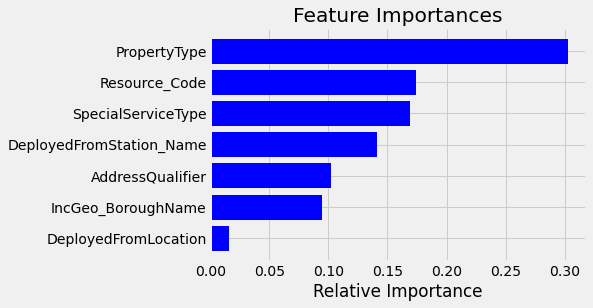

In [11]:
# Chargement modules
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
import xgboost as xgb
import pandas_profiling
import shap
import skater
from IPython.display import display
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

import matplotlib.pyplot as plt
import scikitplot as skplt
%matplotlib inline

############################################ Lecture des fichiers ######################################
##################################### Préparation et analyse des données ###############################

mobilisation = pd.read_csv("LFB Mobilisation data Last 3 years.csv", header=0, sep=";");
incident = pd.read_csv("LFB Incident data Last 3 years.csv", header=0, sep=";");

total = pd.merge(incident, mobilisation, on='IncidentNumber')

#Analyse de la qualité des données
#pandas_profiling.ProfileReport(df)

# suppression des colonnes inutiles
total.drop(["IncidentGroup","PropertyCategory","Postcode_full","UPRN","USRN","IncGeo_BoroughCode","ProperCase",
           "IncGeo_WardCode","IncGeo_WardName","Easting_m","Northing_m","Easting_rounded","Northing_rounded",
           "Latitude","Longitude","FRS","IncidentStationGround","FirstPumpArriving_AttendanceTime",
           "FirstPumpArriving_DeployedFromStation","SecondPumpArriving_AttendanceTime",
           "SecondPumpArriving_DeployedFromStation","NumStationsWithPumpsAttending","NumPumpsAttending",
           "PumpCount","PumpHoursRoundUp","Notional Cost (£)","CalYear_y","HourOfCall_y","ResourceMobilisationId",
           "PerformanceReporting","DateAndTimeMobilised","DateAndTimeMobile","DateAndTimeArrived","TurnoutTimeSeconds",
           "TravelTimeSeconds","DateAndTimeLeft","DateAndTimeReturned","DeployedFromStation_Code","PumpOrder",
           "PlusCode_Code","PlusCode_Description","DelayCodeId","DelayCode_Description"], axis=1, inplace=True)


#On complète les valeurs manquante de la variable 'SpecialServiceType' par la modale de la variable 'StopCodeDescription'
total['SpecialServiceType']=total['SpecialServiceType'].fillna(total['StopCodeDescription'])
total.drop(['StopCodeDescription'], axis=1, inplace=True)

# Conversion de la date et heure en timestamp
#total['timestamp'] = pd.to_datetime(pd.to_datetime(total['DateOfCall']+" "+total['TimeOfCall']), unit='s', origin='unix').astype(int)/1000000000
#total['timestamp'] = datetime.datetime(total['DateOfCall']+" "+total['TimeOfCall']).timestamp()

# Suppression de la colonne Numéro d'incident
# Cette information est purement indicatrice et 
# ne rentre pas en compte dans l'apprentissage du modèle

total = total.drop('IncidentNumber',axis=1)
total = total.drop('CalYear_x',axis=1)
total = total.drop('TimeOfCall', axis=1)
total = total.drop('HourOfCall_x', axis=1)
total = total.drop('DateOfCall', axis=1)
total = total.drop('Postcode_district', axis=1)
total = total.drop('IncGeo_WardNameNew', axis=1)

#Suppression des NaNs restant
total = total.dropna(axis=0)

# Liste des colonnes catégorielles
list_obj=['SpecialServiceType', 'PropertyType', 'AddressQualifier', 'IncGeo_BoroughName', 'Resource_Code', 'DeployedFromStation_Name','DeployedFromLocation']

# Transformation des variables catégorielles en variables indicatrices 
# pour la compatibilité avec le modèle d'apprentissage
enc = OrdinalEncoder()
enc.fit(total[list_obj])
total[list_obj] = enc.transform(total[list_obj])

# Vérification corrélation
#plt.figure(figsize=(16, 15))
#sns.heatmap(total.corr(), annot=True, cmap='RdBu_r', center=0);

# Séparation de la variable cible du reste des autres variables
target = np.array(total.AttendanceTimeSeconds)
data = total.drop('AttendanceTimeSeconds', axis=1)

#On conserve les noms de variable à part
liste_variables = list(data.columns)

#On convertit le dataset en array
data = np.array(data)

# Séparation des données en un ensemble d'apprentissage et un ensemble de Test 
#On créé 4 dataset : 
#   - x_train contient 75% de x  
#   - y_train contient le total.AttendanceTimeSeconds associé à x_train
# => x_train et y_train permettront d'entraîner l'algorithme
#
#   - x_test contient 25% de x  
#   - y_test contient le AttendanceTimeSeconds.Score associé à x_test
# => x_test et y_test permettront d'évaluer la performance de l'algorithme une fois entrainé sur le train
# Ajout du paramètre 'Stratify' pour marquer la même proportion des données test et entrainement ?????
# stratify = target
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=2022)

#On créé un Random Forest de 100 arbres 
rfr = RandomForestRegressor(n_estimators = 100, random_state = 2022)
rfr.fit(X_train, y_train)

#On applique le modèle que l'on vient 
#d'entraîner sur l'échantillon de test
y_pred = rfr.predict(X_test)
print(pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite']))

#Valeur de la qualité de prédiction entre les valeurs prédites et les valeurs observées
print('score train R² :', rfr.score(X_train, y_train))
print('score test R² :', rfr.score(X_test, y_test))

#On va calculer plusieurs erreurs entre la valeur prédite et le score de réel (que nous avions stocké dans y_test)
#     - MAE : Mean Asolute Error
#     - MAPE : Mean Absolute Percentage Error 
# MAE 
erreurs = abs(y_pred - y_test)
print('Mean Absolute Error:', round(np.mean(erreurs), 2))

# MAPE
mape = 100 * (erreurs / y_test)
print('Mean Absolute Percentage Error :', round(np.mean(mape), 2), '%.')

# On calcule le RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

# Interprétation des résultats
# On calcule les variables d’importance du modèle, c’est à dire celles qui contribuent le plus. 
importances = rfr.feature_importances_
indices = np.argsort(importances)

# style du graphique 
plt.style.use('fivethirtyeight')
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [liste_variables[i] for i in indices])
plt.xlabel('Relative Importance')

# Intérprétation des résultats avec skater
interpreter = Interpretation(X_train, feature_names=X_train.columns)

def predict_xg(x):
    return pd.DataFrame(rfr.predict(xgb.DMatrix(x)))

model = InMemoryModel(predict_xg, examples = X_train)

plt.rcParams['figure.figsize'] = (14,7)

plots = interpreter.feature_importance.plot_feature_importance(
    model, ascending=True)

interpreter.partial_dependence.plot_partial_dependence(['SpecialServiceType'], model, grid_resolution=100,
                                                       with_variance=True, figsize=(6, 4));